In [1]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd


In [3]:
df = pd.read_csv('subtaskA_clean_dev_cased.csv')
df.head()

,comment_text,conspiratorial
0,Se non ci fossero soldati non ci sarebbero gue...,0
1,"]( ""Shedding of Infectious SARS-CoV-2 Des...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


## Load Dataset with HF's load_dataset

In [4]:
dataset_hf=load_dataset("csv", data_files='subtaskA_clean_dev_cased.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset_hf

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1840
    })
})

In [6]:
dataset_hf.set_format('pandas')

dataset_hf=dataset_hf['train'][:] #per definire la parte di training
#in questo modo tutto il dataset è settato come training

In [7]:
dataset_hf

,comment_text,conspiratorial
0,Se non ci fossero soldati non ci sarebbero gue...,0
1,"]( ""Shedding of Infectious SARS-CoV-2 Des...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0
...,...,...
1835,avvolge la terra spesso 2000 km Oooh mi ricor...,1
1836,Comunque le recensioni erano negative ancora p...,0
1837,Intanto in Kazakistan la gente che ne ha le pa...,1
1838,Una profezia ad una conferenza del 2015: Il pr...,1


In [8]:
dataset_hf=Dataset.from_pandas(dataset_hf)

In [9]:
dataset_hf = dataset_hf.rename_column("conspiratorial", "labels")

In [10]:
# Train Test Valid Split
train_testvalid = dataset_hf.train_test_split(test_size=0.3,seed=15)

In [11]:
test_valid = train_testvalid['test'].train_test_split(test_size=0.3,seed=15)


dataset_hf = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'], #val2
    'val': test_valid['train']})

dataset_hf

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'labels'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'labels'],
        num_rows: 166
    })
    val: Dataset({
        features: ['comment_text', 'labels'],
        num_rows: 386
    })
})

In [12]:
y_val = list(dataset_hf['val']['labels'])
y_test = list(dataset_hf['test']['labels'])

In [13]:
checkpoint = "Geotrend/distilbert-base-it-cased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer.model_max_len=512

## Vector size "distilbert-base-uncased"

In the model distilbert-base-uncased, each token is embedded into a vector of size 768. The shape of the output from the base model is

### (batch_size, max_sequence_length, embedding_vector_size=768)

In [14]:
def tokenize(batch):
  return tokenizer(batch["comment_text"], truncation=True, max_length=512)

tokenized_dataset = dataset_hf.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 166
    })
    val: Dataset({
        features: ['comment_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 386
    })
})

In [15]:
tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "labels"] ) #cambia il formato per combinare con pytorch

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #forma i batch



https://huggingface.co/docs/transformers/main_classes/data_collator


Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

To be able to build batches, data collators may apply some processing (like padding). Some of them (like DataCollatorForLanguageModeling) also apply some random data augmentation (like random masking) on the formed batch.

data_collator automatically pads the model inputs in a batch to the length of the longest example. This bypasses the need to set a global maximum sequence length, and in practice leads to faster training since we perform fewer redundant computations on the padded tokens and attention masks.


------------

## We construct `MyTaskSpecificCustomModel` class that inherits from the nn.Module.

In [16]:
class MyTaskSpecificCustomModel(nn.Module):
  # posso usare qualsiasi modello hf come body, perché solo l'output layer sarà task specific
    """
    A task-specific custom transformer model. This model loads a pre-trained transformer model and adds a new dropout
    and linear layer at the end for fine-tuning and prediction on specific tasks.
    """
    def __init__(self, checkpoint, num_labels ):
        """
        Args:
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(MyTaskSpecificCustomModel, self).__init__()
        self.num_labels = num_labels

        self.model = model = AutoModel.from_pretrained(checkpoint, config = AutoConfig.from_pretrained(checkpoint,
                                                                                                       output_attention = True,
                                                                                                       output_hidden_state = True ) )
        # New Layer
        self.dropouts = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels ) # --> può anche essere un MLP, LSTM, whatever
        # (valore output hidden states, numero di labels) il numero di output hidden states
        # lo ottengo grazie a output_hidden_state = True

        # il valore di output hidden state può variare in base al modello e lo trovi nella documentazione di hf


    def forward(self, input_ids = None, attention_mask=None, labels = None ):
        """
        Forward pass for the model.

        Args:
            input_ids (torch.Tensor, optional): Tensor of input IDs. Defaults to None.
            attention_mask (torch.Tensor, optional): Tensor for attention masks. Defaults to None.
            labels (torch.Tensor, optional): Tensor for labels. Defaults to None.

        Returns:
            TokenClassifierOutput: A named tuple with the following fields:
            - loss (torch.FloatTensor of shape (1,), optional, returned when label_ids is provided) – Classification loss.
            - logits (torch.FloatTensor of shape (batch_size, num_labels)) – Classification scores before SoftMax.
            - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
            - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) – Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask  )

        last_hidden_state = outputs[0]

        sequence_outputs = self.dropouts(last_hidden_state)

        logits = self.classifier(sequence_outputs[:, 0, : ].view(-1, 768 ))

        #loss = None
        if labels is not None:
          loss_func =  nn.CrossEntropyLoss()
            #loss_func = nn.CrossEntropyLoss() #per problemi multiclasse
            #per problemi binari go for nn.BCELoss()
          loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))

        # backprop eseguita implicitamente

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)



## definizione classe per MLP (da provare)

In [22]:
class MyTaskSpecificCustomModelMLP(nn.Module):
  # posso usare qualsiasi modello hf come body, perché solo l'output layer sarà task specific
    """
    A task-specific custom transformer model. This model loads a pre-trained transformer model and adds a new dropout
    and MLP model at the end for fine-tuning and prediction on specific tasks.
    """
    def __init__(self, checkpoint, num_labels, mlp_hidden_sizes ):
        """
        Args:
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(MyTaskSpecificCustomModelMLP, self).__init__()
        self.num_labels = num_labels

        self.model = model = AutoModel.from_pretrained(checkpoint, config = AutoConfig.from_pretrained(checkpoint,
                                                                                                       output_attention = True,
                                                                                                       output_hidden_state = True ) )
        # New Layer
        self.dropouts = nn.Dropout(0.1)

        # Calculate the input size for the MLP based on the hidden state dimension
        input_size = self.model.config.hidden_size

        # Create the MLP layers
        layers = []
        for hidden_size in mlp_hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            input_size = hidden_size
        self.mlp = nn.Sequential(*layers) # impacchettando i layers e inserendoli nella variabile mlp

        # Output layer
        self.classifier = nn.Linear(768, num_labels )
        # (valore output hidden states, numero di labels) il numero di output hidden states
        # lo ottengo grazie a output_hidden_state = True

        # il valore di output hidden state può variare in base al modello e lo trovo nella documentazione di hf


    def forward(self, input_ids = None, attention_mask=None, labels = None ):
        """
        Forward pass for the model.

        Args:
            input_ids (torch.Tensor, optional): Tensor of input IDs. Defaults to None.
            attention_mask (torch.Tensor, optional): Tensor for attention masks. Defaults to None.
            labels (torch.Tensor, optional): Tensor for labels. Defaults to None.

        Returns:
            TokenClassifierOutput: A named tuple with the following fields:
            - loss (torch.FloatTensor of shape (1,), optional, returned when label_ids is provided) – Classification loss.
            - logits (torch.FloatTensor of shape (batch_size, num_labels)) – Classification scores before SoftMax.
            - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
            - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) – Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask  )

        last_hidden_state = outputs[0]

        sequence_outputs = self.dropouts(last_hidden_state)

        logits = self.classifier(sequence_outputs[:, 0, : ].view(-1, 768 ))


        loss = None
        if labels is not None:
            loss_func = nn.CrossEntropyLoss()
            loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))

            return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)



# Create PyTorch DataLoader

In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset['train'], shuffle = True, batch_size = 8, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    tokenized_dataset['val'], shuffle = True, collate_fn = data_collator
)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #tipico codice torch per definire su cosa runnare
mlp_hidden_sizes=[32, 16, 8]
model_task_specific = MyTaskSpecificCustomModelMLP(checkpoint=checkpoint, num_labels=2, mlp_hidden_sizes=mlp_hidden_sizes ).to(device)
#.to() trasferisce il modello al device

In [25]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model_task_specific.parameters(), lr = 5e-5 )
# passo parametri e lr a optimizer

num_epoch = 3

num_training_steps = num_epoch * len(train_dataloader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer = optimizer,
    num_warmup_steps = 0, #dont need
    num_training_steps = num_training_steps,

)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
from datasets import load_metric
metric = load_metric("f1")

<ipython-input-26-e4b2221a8929>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


# Training

In [27]:
from tqdm.auto import tqdm

In [28]:
progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epoch * len(eval_dataloader) ))

train_losses = []
val_losses = []


# train
for epoch in range(num_epoch):
    model_task_specific.train()
    train_epoch_loss = 0.0  # Inizializza la loss di addestramento per l'epoca corrente
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)

        train_epoch_loss += loss.item()  # Aggiungi la loss di addestramento all'accumulatore

    train_losses.append(train_epoch_loss / len(train_dataloader))
# eval

    y_pred = []
    model_task_specific.eval()
    val_epoch_loss = 0.0  # Inizializza la loss di validazione per l'epoca corrente
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(): # da usare in val e test
            outputs = model_task_specific(**batch)

        val_loss = outputs.loss
        val_epoch_loss += val_loss.item()  # Aggiungi la loss di validazione all'accumulatore

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        y_pred.extend(predictions.tolist())
        metric.add_batch(predictions=predictions, references=batch['labels'])
        progress_bar_eval.update(1)

    val_losses.append(val_epoch_loss / len(eval_dataloader))  # Aggiungi la loss media di validazione alla lista

    print(metric.compute()) # per ogni batch



  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/1158 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': 0.7821522309711285}
{'f1': 0.8144578313253013}
{'f1': 0.7760416666666667}


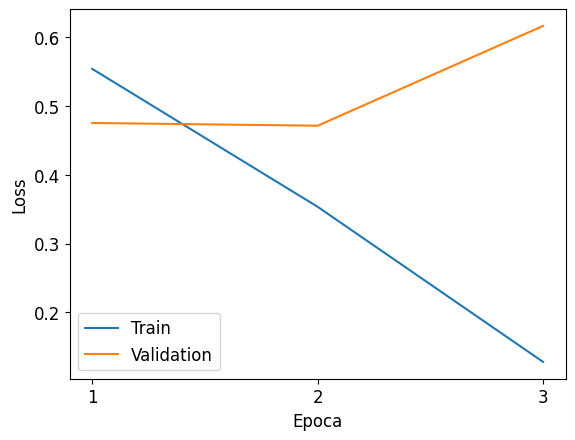

In [29]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
plt.plot(range(1, num_epoch + 1), train_losses, label='Train')
plt.plot(range(1, num_epoch + 1), val_losses, label='Validation')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1, num_epoch + 1))
plt.show()

In [30]:
from sklearn.metrics import classification_report

report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.53      0.52       187
           1       0.53      0.49      0.51       199

    accuracy                           0.51       386
   macro avg       0.51      0.51      0.51       386
weighted avg       0.51      0.51      0.51       386



## Post Training Evaluation (on val2)

In [31]:
model_task_specific.eval()

test_dataloader = DataLoader(
    tokenized_dataset['test'], batch_size = 8, collate_fn = data_collator
)

y_pred_test = []
for batch in test_dataloader:
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad():
        outputs = model_task_specific(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim = -1)
    y_pred_test.extend(predictions.tolist())
    metric.add_batch(predictions = predictions, references=batch['labels'] )

metric.compute()


{'f1': 0.7453416149068324}

{'f1': 0.7439024390243902}

In [32]:
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        85
           1       0.75      0.74      0.75        81

    accuracy                           0.75       166
   macro avg       0.75      0.75      0.75       166
weighted avg       0.75      0.75      0.75       166

